# **LOAD DATA**

In [1]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/kaggle.json

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d deadskull7/fer2013
!kaggle datasets download -d davilsena/ckdataset


Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
License(s): CC0-1.0
 86% 83.0M/96.6M [00:00<00:00, 86.4MB/s]
100% 96.6M/96.6M [00:01<00:00, 97.9MB/s]
Dataset URL: https://www.kaggle.com/datasets/davilsena/ckdataset
License(s): CC0-1.0
  0% 0.00/2.48M [00:00<?, ?B/s]
100% 2.48M/2.48M [00:00<00:00, 60.1MB/s]


In [7]:
!unzip fer2013.zip
!unzip ckdataset.zip

Archive:  fer2013.zip
  inflating: fer2013.csv             
Archive:  ckdataset.zip
  inflating: ckextended.csv          


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# **DATA INFORMATION**

In [9]:
data_fer = pd.read_csv('fer2013.csv')
data_ck = pd.read_csv('ckextended.csv')
data_laugh = pd.read_csv('/content/drive/MyDrive/image/new_dataset.csv')
data_confused = pd.read_csv('/content/drive/MyDrive/image/confused.csv')

data_fer.head()
data_ck.head()
data_laugh.head()
data_confused.head()

,emotion,pixels,Usage
0,7,30 35 47 79 137 180 123 132 163 196 147 197 15...,Training
1,7,117 108 120 120 120 160 198 212 217 217 218 21...,Training
2,7,176 176 151 81 47 66 101 116 122 131 140 140 1...,Training
3,7,69 72 75 93 113 116 128 138 146 169 165 172 18...,Training
4,7,17 23 22 37 23 18 29 28 21 8 7 17 27 44 42 43 ...,Training


In [10]:
data_fer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [11]:
data_ck.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  920 non-null    int64 
 1   pixels   920 non-null    object
 2   Usage    920 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.7+ KB


In [12]:
data_laugh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  20 non-null     int64 
 1   pixels   20 non-null     object
 2   Usage    20 non-null     object
dtypes: int64(1), object(2)
memory usage: 608.0+ bytes


In [13]:
data_confused.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  30 non-null     int64 
 1   pixels   30 non-null     object
 2   Usage    30 non-null     object
dtypes: int64(1), object(2)
memory usage: 848.0+ bytes


In [14]:
data_ck['emotion'] = 9  # Örnek olarak 9(Contempt) numaralı kategori olarak tanımlanmıştır
data_laugh['emotion'] = 7
data_confused['emotion'] = 8

# Veri setlerini birleştirme işlemi
df = pd.concat([data_fer, data_ck[['emotion', 'pixels', 'Usage']]])
df = pd.concat([df, data_laugh[['emotion', 'pixels', 'Usage']]])
df = pd.concat([df, data_confused[['emotion', 'pixels', 'Usage']]])
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training



*   **emotion : {0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad,5=Surprise, 6=Neutral, 7=Laugh, 8=Confused, 9=Contempt}**
*   **pixels**
*   **Usage : {Training, PublicTest, PrivateTest}**



In [15]:
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36857 entries, 0 to 29
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  36857 non-null  int64 
 1   pixels   36857 non-null  object
 2   Usage    36857 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [17]:
emotion_labels = {0:'Angry', 1:'Digust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral', 7:'Laugh', 8:'Confused', 9:"Contempt"}
emotion_counts = df['emotion'].value_counts(sort=True).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_labels)

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
emotion,36857.0,3.470765,2.055864,0.0,2.0,3.0,5.0,9.0


<ipython-input-19-ed7c72fb043b>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=emotion_counts_sorted.emotion, y=emotion_counts_sorted.number, palette='husl')


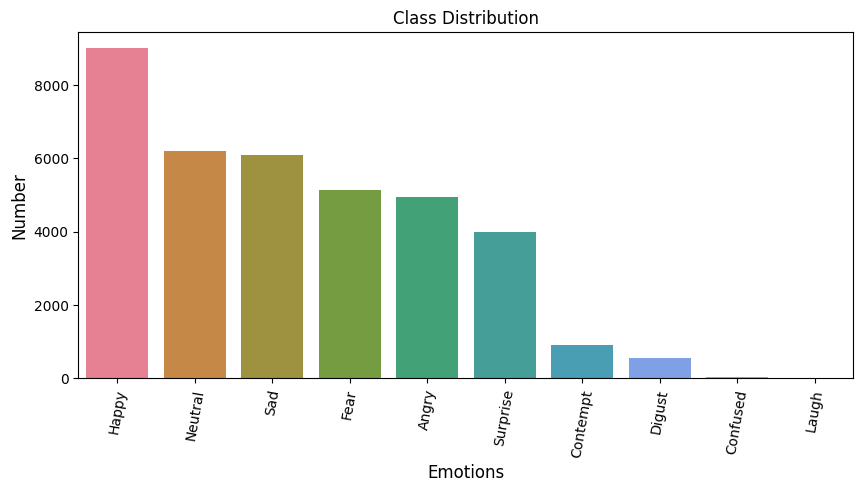

In [19]:
emotion_counts_sorted = emotion_counts.sort_values(by='number', ascending=False)
plt.figure(figsize=(10, 4.5))
sns.barplot(x=emotion_counts_sorted.emotion, y=emotion_counts_sorted.number, palette='husl')
plt.title('Class Distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.xticks(rotation=80)
plt.show()

In [20]:
df.Usage.value_counts()

Usage
Training       29483
PrivateTest     3689
PublicTest      3685
Name: count, dtype: int64

In [21]:
data_train = df[df['Usage'] == 'Training'].copy()
data_val = df[df['Usage'] == 'PublicTest'].copy()
data_test = df[df['Usage'] == 'PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (29483, 3), 
validation shape: (3685, 3), 
test shape: (3689, 3)


# **Visualize the Training Dataset**

---



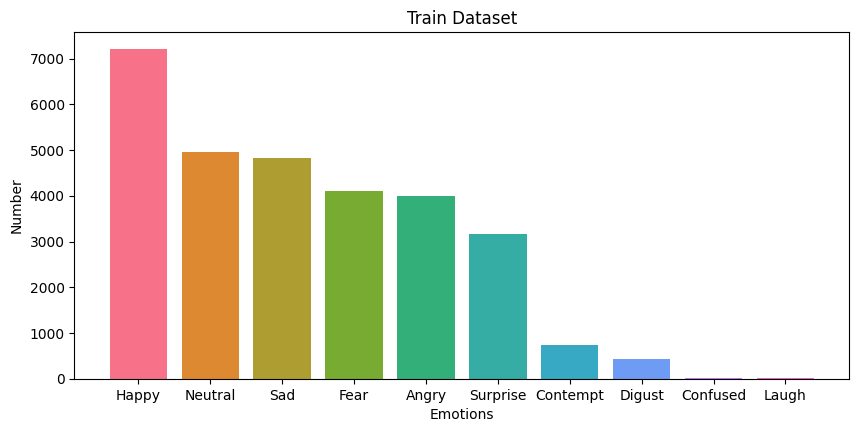

In [22]:
train_emotion_counts_sorted = data_train['emotion'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 4.5))
colors = sns.color_palette("husl", n_colors=len(train_emotion_counts_sorted))
plt.bar(range(len(train_emotion_counts_sorted)), train_emotion_counts_sorted.values, color=colors)
plt.xticks(range(len(train_emotion_counts_sorted)), [emotion_labels[i] for i in train_emotion_counts_sorted.index])
plt.title('Train Dataset')
plt.ylabel('Number')
plt.xlabel('Emotions')
plt.show()

# **Visualize the Testing Dataset**

---



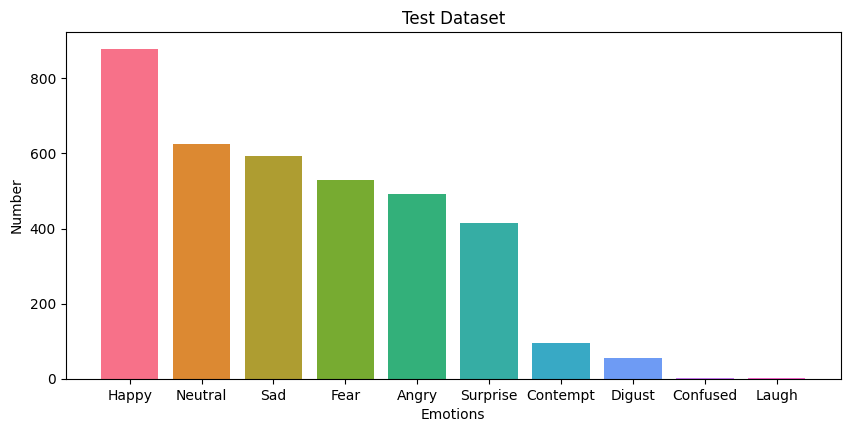

In [23]:
test_emotion_counts_sorted = data_test['emotion'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 4.5))
colors = sns.color_palette("husl", n_colors=len(test_emotion_counts_sorted))
plt.bar(range(len(test_emotion_counts_sorted)), test_emotion_counts_sorted.values, color=colors)
plt.xticks(range(len(test_emotion_counts_sorted)), [emotion_labels[i] for i in test_emotion_counts_sorted.index])
plt.title('Test Dataset')
plt.ylabel('Number')
plt.xlabel('Emotions')
plt.show()

# **Visualize the Validation Dataset**


---



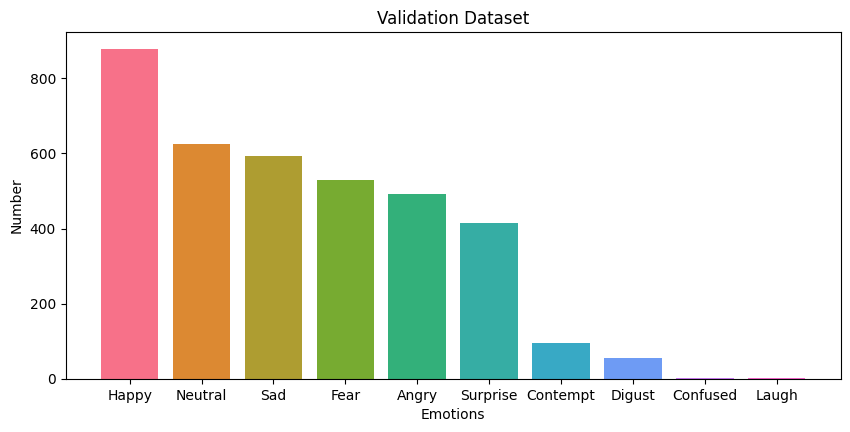

In [24]:
val_emotion_counts_sorted = data_test['emotion'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 4.5))
colors = sns.color_palette("husl", n_colors=len(val_emotion_counts_sorted))
plt.bar(range(len(val_emotion_counts_sorted)), val_emotion_counts_sorted.values, color=colors)
plt.xticks(range(len(val_emotion_counts_sorted)), [emotion_labels[i] for i in val_emotion_counts_sorted.index])
plt.title('Validation Dataset')
plt.ylabel('Number')
plt.xlabel('Emotions')
plt.show()

# **Normalization**

---



In [26]:
def prepare_data(data):
    x = []
    for pixel_sequence in data["pixels"]:
        pixels = np.array(pixel_sequence.split(" "), dtype='float32').reshape(48, 48, 1)
        x.append(pixels)
    x = np.array(x) / 255.0
    y = to_categorical(data["emotion"], num_classes=10)
    return x, y



# **Model**

---



In [27]:
def prepare_data(df):
    x = []
    for pixel_sequence in df["pixels"]:
        pixels = np.array(pixel_sequence.split(" "), dtype='float32').reshape(48, 48, 1)
        x.append(pixels)
    x = np.array(x) / 255.0
    y = to_categorical(df["emotion"], num_classes=10)
    return x, y

x, y = prepare_data(df)

x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

model.save('LeNet5_model.h5')

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')


Epoch 1/20
922/922 [==============================] - 49s 53ms/step - loss: 1.7134 - accuracy: 0.3356 - val_loss: 1.5426 - val_accuracy: 0.4029
Epoch 2/20
922/922 [==============================] - 47s 51ms/step - loss: 1.4728 - accuracy: 0.4340 - val_loss: 1.4559 - val_accuracy: 0.4403
Epoch 3/20
922/922 [==============================] - 49s 53ms/step - loss: 1.3728 - accuracy: 0.4779 - val_loss: 1.4044 - val_accuracy: 0.4696
Epoch 4/20
922/922 [==============================] - 47s 51ms/step - loss: 1.2979 - accuracy: 0.5053 - val_loss: 1.3649 - val_accuracy: 0.4864
Epoch 5/20
922/922 [==============================] - 47s 51ms/step - loss: 1.2365 - accuracy: 0.5270 - val_loss: 1.3400 - val_accuracy: 0.4927
Epoch 6/20
922/922 [==============================] - 50s 55ms/step - loss: 1.1799 - accuracy: 0.5523 - val_loss: 1.3053 - val_accuracy: 0.5076
Epoch 7/20
922/922 [==============================] - 45s 49ms/step - loss: 1.1251 - accuracy: 0.5758 - val_loss: 1.3032 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 2s 17ms/step - loss: 2.1722 - accuracy: 0.5071
Test accuracy: 0.5070537328720093


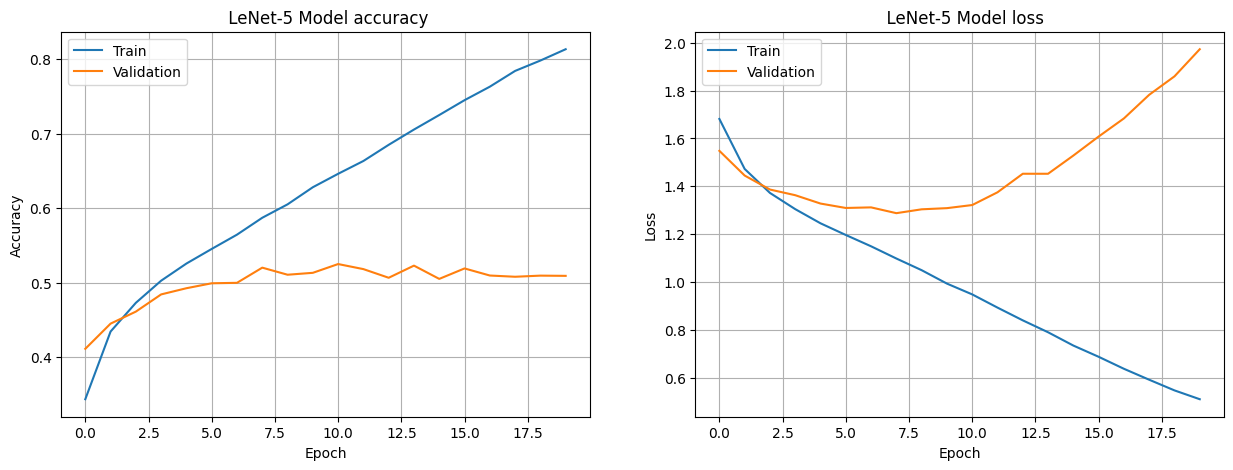

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title(' LeNet-5 Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('  LeNet-5 Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
from keras.layers import Flatten, Dense
from keras.models import Model
from keras.losses import categorical_crossentropy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split

pixel_list = df['pixels'].to_list()
Arr = []
for pix in pixel_list:
    img = [int(pixel) for pixel in pix.split(' ')]
    img = np.asarray(img).reshape(48, 48)
    Arr.append(img.astype('float32') / 255.0)
X = np.array(Arr)
X = np.expand_dims(X, -1)
X.shape
y = df['emotion'].values
y.shape


x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state = 42)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



history = model.fit(x_train, y_train, epochs=20, validation_split=0.2)
model.save('model.h5')

Epoch 1/20
829/829 [==============================] - 83s 99ms/step - loss: 1.6734 - accuracy: 0.3500 - val_loss: 1.5260 - val_accuracy: 0.4167
Epoch 2/20
829/829 [==============================] - 84s 101ms/step - loss: 1.4353 - accuracy: 0.4521 - val_loss: 1.4039 - val_accuracy: 0.4697
Epoch 3/20
829/829 [==============================] - 85s 103ms/step - loss: 1.3232 - accuracy: 0.4981 - val_loss: 1.3253 - val_accuracy: 0.4970
Epoch 4/20
829/829 [==============================] - 81s 98ms/step - loss: 1.2486 - accuracy: 0.5289 - val_loss: 1.3150 - val_accuracy: 0.5047
Epoch 5/20
829/829 [==============================] - 83s 100ms/step - loss: 1.1866 - accuracy: 0.5529 - val_loss: 1.2963 - val_accuracy: 0.5163
Epoch 6/20
829/829 [==============================] - 79s 96ms/step - loss: 1.1299 - accuracy: 0.5772 - val_loss: 1.2807 - val_accuracy: 0.5158
Epoch 7/20
829/829 [==============================] - 87s 105ms/step - loss: 1.0769 - accuracy: 0.5961 - val_loss: 1.3018 - val_accur

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


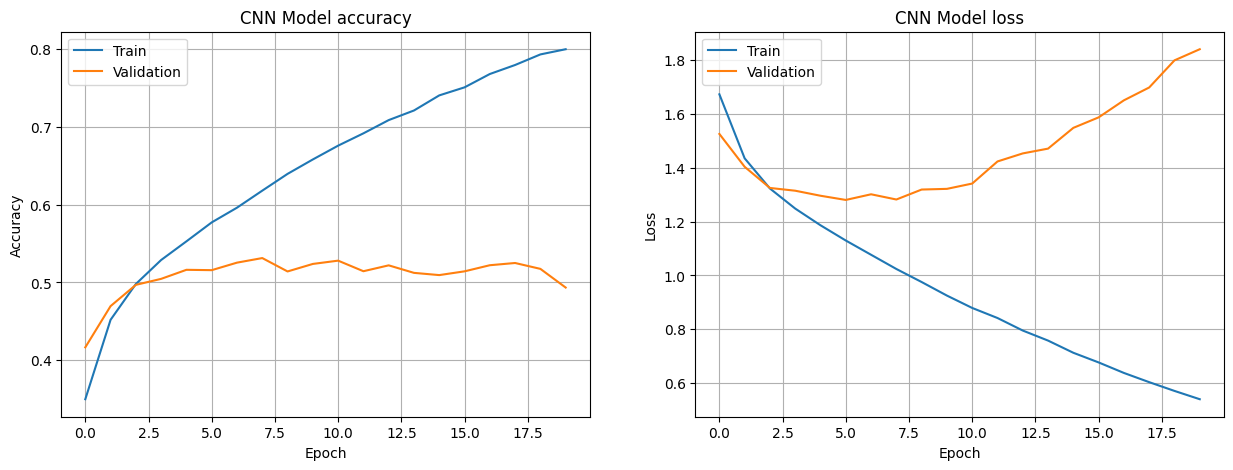

In [ ]:

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('CNN Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid(True)

plt.show()

In [ ]:
from google.colab import files
files.download('model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **All Code**

In [ ]:
import pandas as pd
import numpy as np
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

data_fer = pd.read_csv('fer2013.csv')
data_ck = pd.read_csv('ckextended.csv')
data_new = pd.read_csv('/content/drive/MyDrive/image/laugh.csv')

data_ck['emotion'] = 9
data_new['emotion'] = 7

df = pd.concat([data_fer, data_ck[['emotion', 'pixels', 'Usage']]])
df = pd.concat([df, data_new[['emotion', 'pixels', 'Usage']]])

data_train = df[df['Usage'] == 'Training'].copy()
data_val = df[df['Usage'] == 'PublicTest'].copy()
data_test = df[df['Usage'] == 'PrivateTest'].copy()
emotion_labels = {0:'Angry', 1:'Digust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral', 7:'Laugh',9:"Contempt"}
emotion_counts = df['emotion'].value_counts(sort=True).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_labels)
def prepare_data(data):
    x = []
    for pixel_sequence in data["pixels"]:
        pixels = np.array(pixel_sequence.split(" "), dtype='float32').reshape(48, 48, 1)
        x.append(pixels)
    x = np.array(x) / 255.0
    y = to_categorical(data["emotion"], num_classes=10)
    return x, y

x_train, y_train = prepare_data(data_train)
x_val, y_val = prepare_data(data_val)
x_test, y_test = prepare_data(data_test)

model = Sequential()
model.add(Conv2D(6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(48, 48, 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

model.save('LeNet5_model.h5')

test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')


Epoch 1/20
921/921 [==============================] - 44s 47ms/step - loss: 1.6624 - accuracy: 0.3540 - val_loss: 1.4886 - val_accuracy: 0.4200
Epoch 2/20
921/921 [==============================] - 42s 45ms/step - loss: 1.4403 - accuracy: 0.4478 - val_loss: 1.3739 - val_accuracy: 0.4730
Epoch 3/20
921/921 [==============================] - 40s 44ms/step - loss: 1.3177 - accuracy: 0.4975 - val_loss: 1.3237 - val_accuracy: 0.5031
Epoch 4/20
921/921 [==============================] - 44s 48ms/step - loss: 1.2293 - accuracy: 0.5313 - val_loss: 1.2699 - val_accuracy: 0.5151
Epoch 5/20
921/921 [==============================] - 41s 44ms/step - loss: 1.1551 - accuracy: 0.5641 - val_loss: 1.2739 - val_accuracy: 0.5162
Epoch 6/20
921/921 [==============================] - 41s 45ms/step - loss: 1.0831 - accuracy: 0.5952 - val_loss: 1.2802 - val_accuracy: 0.5210
Epoch 7/20
921/921 [==============================] - 43s 47ms/step - loss: 1.0171 - accuracy: 0.6170 - val_loss: 1.2738 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


116/116 [==============================] - 2s 14ms/step - loss: 2.7279 - accuracy: 0.5189
Test accuracy: 0.5188500285148621


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
from keras.utils import to_categorical


y_test_encoded = to_categorical(y_test)


model_names = [
    'model',
    'LeNet5_model'
]

model = load_model('model.h5')
LeNet5_model = load_model('LeNet5_model.h5')

models = [model, LeNet5_model]

rows = []
model_predictions = []

for model_name, model in zip(model_names, models):
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    model_predictions.append(predictions)

    mae = mean_absolute_error(y_test_encoded, predictions)
    mse = mean_squared_error(y_test_encoded, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test_encoded, predictions)
    mape = np.mean(np.abs((y_test_encoded - predictions) / y_test_encoded)) * 100

    rows.append({"Model": model_name, "MAE": mae, "MSE": mse, "RMSE": rmse, "R^2": r2, "MAPE": mape})

metrics_df = pd.DataFrame(rows)


print(metrics_df)

116/116 [==============================] - 3s 21ms/step


<ipython-input-42-fd12d1cd3ecc>:35: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_encoded - predictions) / y_test_encoded)) * 100


116/116 [==============================] - 2s 14ms/step
          Model       MAE       MSE      RMSE       R^2  MAPE
0         model  0.104624  0.065824  0.256563  0.222293   inf
1  LeNet5_model  0.107387  0.068992  0.262662  0.183082   inf


<ipython-input-42-fd12d1cd3ecc>:35: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_test_encoded - predictions) / y_test_encoded)) * 100


# **Test**

---



/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 192ms/step


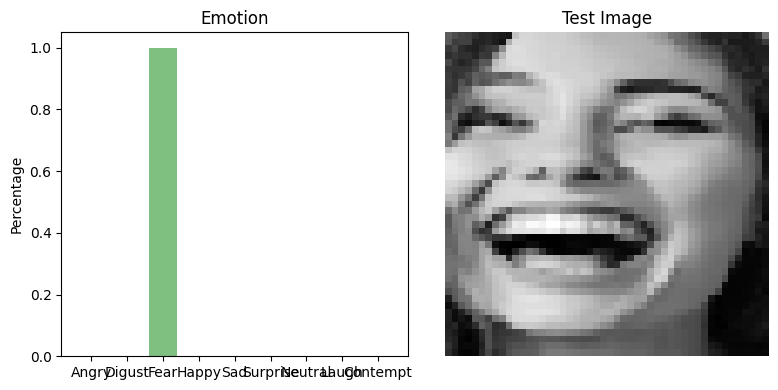

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
model = load_model('LeNet5_model.h5')

test_image = "laugh.png"

img = image.load_img(test_image, target_size=(48, 48), grayscale=True)
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

custom = model.predict(img_array)

objects = ('Angry', 'Digust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral','Laugh', 'Contempt')


plt.figure(figsize=(8, 4))


plt.subplot(1, 2, 1)
plt.bar(range(len(objects)), custom[0][:len(objects)], align='center', alpha=0.5, color='g')
plt.xticks(range(len(objects)), objects)
plt.ylabel('Percentage')
plt.title('Emotion')


plt.subplot(1, 2, 2)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Test Image')

plt.tight_layout()
plt.show()